<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/BOW_LR/FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import random
import pandas as pd
import re
import nltk
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import kagglehub

In [4]:
dataset_dir = "./fake_news_dataset"

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# download the dataset
dataset_name = "emineyetm/fake-news-detection-datasets"
print(f"Downloading dataset: {dataset_name}")
os.system(f"kaggle datasets download -d {dataset_name} -p {dataset_dir}")

# Extract the dataset
zip_file = None
for file in os.listdir(dataset_dir):
    if file.endswith(".zip"):
        zip_file = os.path.join(dataset_dir, file)
        break

if not zip_file:
    raise FileNotFoundError("No zip file found in the dataset directory.")

print(f"Extracting {zip_file}...")
with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall(dataset_dir)

# Dynamically locate CVSs
fake_path, true_path = None, None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Fake.csv" in file:
            fake_path = os.path.join(root, file)
        if "True.csv" in file:
            true_path = os.path.join(root, file)

Extracting ./fake_news_dataset/fake-news-detection-datasets.zip...


In [5]:

# Load datasets
fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

# Add labels and combine datasets
fake_df['label'] = 0  # Fake news labeled as 0
true_df['label'] = 1  # True news labeled as 1
df = pd.concat([fake_df, true_df]).reset_index(drop=True)

print("Combined Dataset Preview:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

# missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
df.dropna(subset=['text', 'label'], inplace=True)

# Filter the data
filtered_texts = []
filtered_labels = []
for text, label in zip(df['text'], df['label']):
    if len(text) > 50 and text not in filtered_texts:
        filtered_texts.append(text)
        filtered_labels.append(label)

# Create new filtered DataFrame
filtered_df = pd.DataFrame({'text': filtered_texts, 'label': filtered_labels})


Combined Dataset Preview:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  

Dataset statistics:
              label
count  44898.000000
mean       

In [6]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

# text preprocessing
filtered_df['processed_text'] = filtered_df['text'].apply(preprocess_text)

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['processed_text'], filtered_df['label'], test_size=0.2, random_state=42
)


Model Accuracy: 0.99
Unique classes in test labels: [0, 1]

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.98      0.99      3466
        True       0.99      0.99      0.99      4235

    accuracy                           0.99      7701
   macro avg       0.99      0.99      0.99      7701
weighted avg       0.99      0.99      0.99      7701



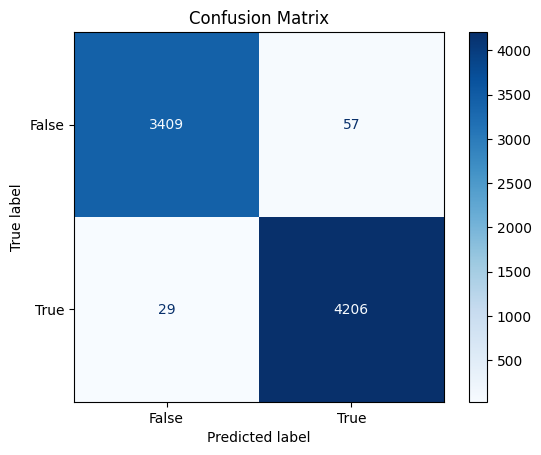


Sample Predictions:

Sample 1
Text: a woman was raped by a football player at the university of north carolina and she says that when she reported the attack to campus police they laughed in her facedelaney robinson decided to go public with her horrific ordeal because she felt it would be the only way to get justice since the school would obviously rather protect a sports star than prosecute a sexual assault speaking at a press conference robinson said that on the night of feb 14 tar heels junior linebacker allen artis brutally raped her in a dorm room while she was  incapacitated denise branch robinson s attorney said that her client went to the hospital following the assault where they examined her and collected evidence with a rape kit according to hospital records robinson suffered  vaginal injuries consistent with bluntforce trauma and bruising consistent with a physical assault but when she reported the sexual assault to campus police they simply laughed in her face and asked h

In [7]:
# Tfidf
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Model Training with Logistic Regression
model = LogisticRegression(max_iter=200, solver='saga', penalty='l2', C=1.0)
model.fit(X_train, train_labels)

# Predict on the test set
predictions = model.predict(X_test)

accuracy = accuracy_score(test_labels, predictions)
print(f"\nModel Accuracy: {accuracy:.2f}")

# single class cases
unique_classes = sorted(test_labels.unique())
print("Unique classes in test labels:", unique_classes)

target_names = ['False', 'True'][:len(unique_classes)]

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, predictions, labels=unique_classes, target_names=target_names))

# Confusion Matrix
if len(unique_classes) > 1:  # Plot confusion matrix only if there are at least two classes
    conf_matrix = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("\nConfusion Matrix not displayed due to single class in the test set.")

# Display a few predictions
print("\nSample Predictions:")
for i, (text, pred, true_label) in enumerate(zip(test_texts[:5], predictions[:5], test_labels[:5])):
    print(f"\nSample {i+1}")
    print(f"Text: {text}")
    print(f"Predicted: {'True' if pred else 'False'}, Actual: {'True' if true_label else 'False'}")